<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import io

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Training data set

For task 1 of Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains 18.800 binary images of handwritten characters of size (28,28). Each of these images depicts one of 893 different characters from 29 different alphabets. Each image is accompanied by a label that is encoded as an interger $y\in\{0, 1, ..., 892\}$ that indicate the caracter depicted in the image. The following cell provides code that loads the data from hardcoded URLs.

You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 


In [ ]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
# Downloading may take a while..
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/tvQmLyY7MhVsADb/download')
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/z234AHrQqx9RVGH/download')
train_y = list(train_y)




In [ ]:

from torch.utils.data import Dataset
from torchvision import transforms
import torchvision

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
      
        self.transform = transform
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, index):

        x = self.data[index]
        y = self.target[index]     

        if self.transform:
          x = self.transform(x)

        return x, y



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

train_x = train_x + 0
omniglot = MyDataset(train_x,train_y,transform=transform)



### Query data set

For this task you need to use the following query data set. The dataset contains 100 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 

Each test set consists of 1 query image and 5 candidate images. All images are the same size (28x28). The test data is organized in two numpy arrays. One for the query images with shape (100, 1, 28, 28) and another for the candidate imagaes with shape (100, 5, 28, 28). 

The task is to develop a model that enables selecting the image which is depicting the same character as the anchor image out of 5 test images. These test images are declared in the `query_x` numpy array . 

Finally, we plot the first 5 cases in the query dataset. The first column corresponds with the anchor images of each of the 5 cases. All other images are test images from which the task is to recognize the anchor image. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the anchor image. 

In [ ]:
query_dataset = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/YGn5gb7unBEuCLB/download")
queries_true = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/0sPeeIFB3W9RPZG/download")

queries, candidates_sets = np.split(query_dataset, [1], axis=1)
print(f"query images have shape: {queries.shape}")
print(f"target sets have shape: {candidates_sets.shape}")
print(f"ground truth: {queries_true.shape}")


query images have shape: (100, 1, 28, 28)
target sets have shape: (100, 5, 28, 28)
ground truth: (100,)


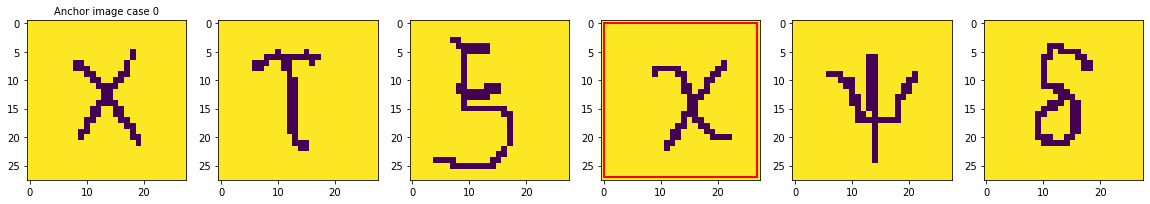

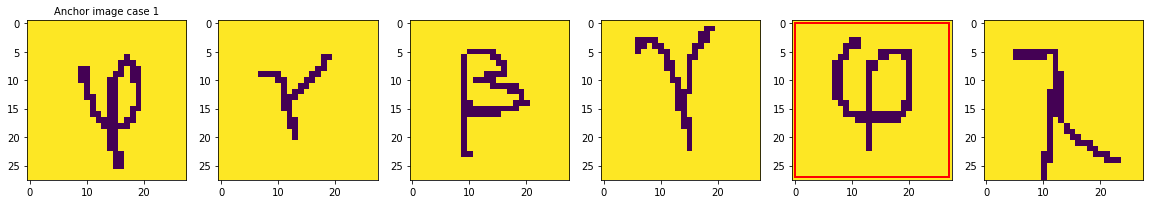

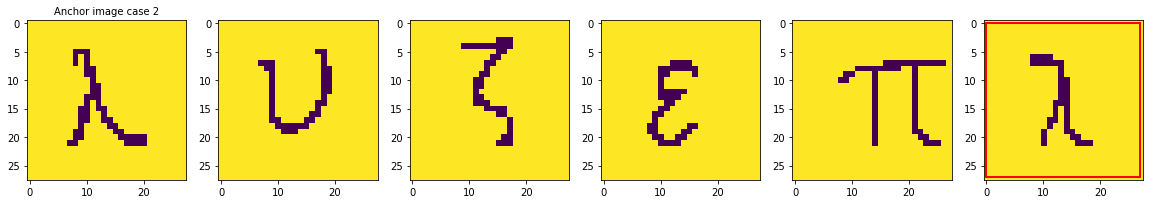

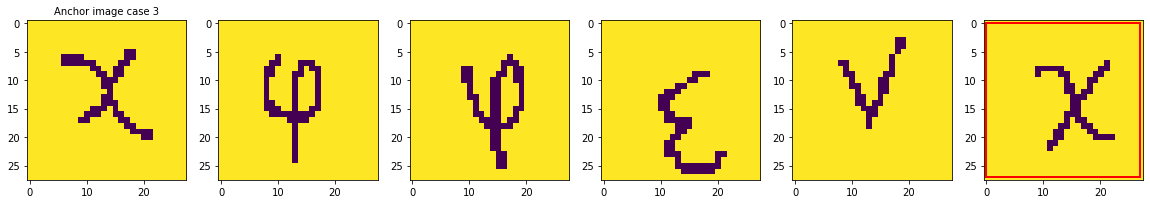

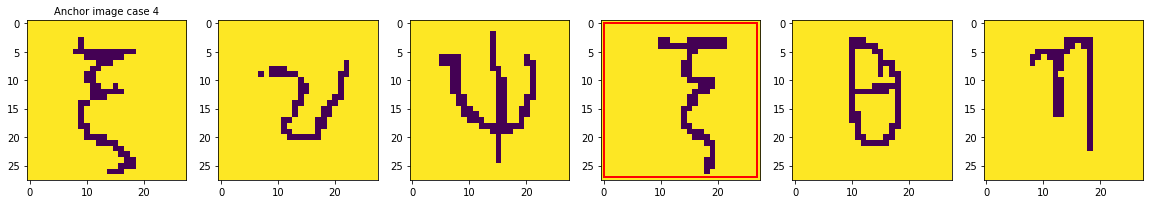

In [ ]:
from matplotlib.patches import Rectangle

def plot_case(caseID):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))
    
    # plot anchor image
    axes[0].imshow(queries[caseID, 0])
    axes[0].set_title(f"Anchor image case {caseID}", fontsize=10)
    
    # show all test images images 
    [ax.imshow(candidates_sets[caseID, i]) for i, ax in enumerate(axes[1:])]
    
    
    # Add the patch to the Axes
    axes[queries_true[caseID]].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))
    
    
    
    
# plot the first five samples of the query datset
[plot_case(caseID) for caseID in range(5)] ;

In [ ]:
from torch.utils.data.sampler import BatchSampler
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [ ]:
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import torch

train_batch_sampler = BalancedBatchSampler(omniglot.target, n_classes=940, n_samples=2)

triplets_train_loader = torch.utils.data.DataLoader(omniglot, batch_sampler=train_batch_sampler)




In [ ]:
from itertools import combinations

class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2)) 

            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

In [ ]:
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [ ]:
from itertools import combinations
class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()
  
        self.margin = margin
  
   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):
        
        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None
    

    def get_triplets(self, embeddings, labels):
        
        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            #randomly choose one negative example in the mined informative examples (semihard or hard negative samples) such that the triplets formed is semihard or hard triplet.
            
            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                
                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

            if len(triplets) == 0:
                triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)
        
        return torch.LongTensor(triplets)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2) 
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(256*3*3, 512)
        self.fc2 = nn.Linear(512, 20)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128= nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
      x = x.float()
      #Block 1
      x = self.conv1(x)
      x = self.relu(self.bn64(x))
      x = self.pool(x)

      #Block 2
      x = self.conv2(x) 
      x = self.relu(self.bn128(x))
      x = self.pool(x)

      #Block 3
      x = self.conv3(x) 
      x = self.relu(self.bn256(x))
      x = self.pool(x)

      #Dense
      x = x.reshape(x.size(0), -1)
      x = self.fc1(x)
      x = self.dropout(x)

      prediction = self.fc2(x)


      return prediction

    
    def get_embedding(self, x):
        return self.forward(x)

In [ ]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

            
        anchor_idx= triplets[:, 0]  
        positive_idx= triplets[:, 1] 
        negative_idx= triplets[:, 2]
            
        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)

        losses = F.relu(ap_distances - an_distances + self.margin)
        return losses.mean()

In [ ]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                #  validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        # self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs




    def run_trainer(self):

        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            for batch in self.training_DataLoader:
                x,y=batch

                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass

                loss = self.criterion(out, target)  # calculate loss
                loss_value = loss.item()
                
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            train_losses.append(loss_value)

            self.model.eval()  # evaluation mode
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end='\n')


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')


train_losses = []

# model
mined_embedding_net = EmbeddingNet()
mined_model = mined_embedding_net.to(device)

# margin value
margin=2

# criterion
criterion = TripletLoss(margin,  Informative_Negative_TripletSelector(margin))

# optimizer
optimizer = torch.optim.Adam(mined_model.parameters(), lr=0.001)

# trainer
trainer = Trainer(model=mined_model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  # validation_DataLoader=triplets_test_loader,
                  epochs=50)

# start training
trainer.run_trainer()

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'\nThe model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(mined_model)


  2%|▏         | 1/50 [00:02<02:01,  2.48s/it]

EPOCH: 01/50 LOSS: 3.5046



  4%|▍         | 2/50 [00:04<01:57,  2.45s/it]

EPOCH: 02/50 LOSS: 2.7381



  6%|▌         | 3/50 [00:07<01:54,  2.44s/it]

EPOCH: 03/50 LOSS: 2.6069



  8%|▊         | 4/50 [00:09<01:51,  2.43s/it]

EPOCH: 04/50 LOSS: 2.4448



 10%|█         | 5/50 [00:12<01:49,  2.43s/it]

EPOCH: 05/50 LOSS: 2.3600



 12%|█▏        | 6/50 [00:14<01:46,  2.41s/it]

EPOCH: 06/50 LOSS: 2.2887



 14%|█▍        | 7/50 [00:16<01:43,  2.41s/it]

EPOCH: 07/50 LOSS: 2.2523



 16%|█▌        | 8/50 [00:19<01:40,  2.40s/it]

EPOCH: 08/50 LOSS: 2.2344



 18%|█▊        | 9/50 [00:21<01:37,  2.38s/it]

EPOCH: 09/50 LOSS: 2.1982



 20%|██        | 10/50 [00:23<01:35,  2.38s/it]

EPOCH: 10/50 LOSS: 2.1854



 22%|██▏       | 11/50 [00:26<01:32,  2.37s/it]

EPOCH: 11/50 LOSS: 2.1689



 24%|██▍       | 12/50 [00:28<01:30,  2.39s/it]

EPOCH: 12/50 LOSS: 2.1625



 26%|██▌       | 13/50 [00:31<01:28,  2.39s/it]

EPOCH: 13/50 LOSS: 2.1504



 28%|██▊       | 14/50 [00:33<01:25,  2.38s/it]

EPOCH: 14/50 LOSS: 2.1604



 30%|███       | 15/50 [00:35<01:23,  2.39s/it]

EPOCH: 15/50 LOSS: 2.1527



 32%|███▏      | 16/50 [00:38<01:21,  2.38s/it]

EPOCH: 16/50 LOSS: 2.1330



 34%|███▍      | 17/50 [00:40<01:18,  2.38s/it]

EPOCH: 17/50 LOSS: 2.1331



 36%|███▌      | 18/50 [00:43<01:15,  2.37s/it]

EPOCH: 18/50 LOSS: 2.1200



 38%|███▊      | 19/50 [00:45<01:13,  2.36s/it]

EPOCH: 19/50 LOSS: 2.1216



 40%|████      | 20/50 [00:47<01:11,  2.38s/it]

EPOCH: 20/50 LOSS: 2.1198



 42%|████▏     | 21/50 [00:50<01:08,  2.37s/it]

EPOCH: 21/50 LOSS: 2.1259



 44%|████▍     | 22/50 [00:52<01:06,  2.36s/it]

EPOCH: 22/50 LOSS: 2.1246



 46%|████▌     | 23/50 [00:54<01:03,  2.36s/it]

EPOCH: 23/50 LOSS: 2.1141



 48%|████▊     | 24/50 [00:57<01:00,  2.34s/it]

EPOCH: 24/50 LOSS: 2.1094



 50%|█████     | 25/50 [00:59<00:58,  2.34s/it]

EPOCH: 25/50 LOSS: 2.1001



 52%|█████▏    | 26/50 [01:01<00:56,  2.34s/it]

EPOCH: 26/50 LOSS: 2.0966



 54%|█████▍    | 27/50 [01:04<00:53,  2.33s/it]

EPOCH: 27/50 LOSS: 2.0988



 56%|█████▌    | 28/50 [01:06<00:51,  2.33s/it]

EPOCH: 28/50 LOSS: 2.0977



 58%|█████▊    | 29/50 [01:08<00:48,  2.33s/it]

EPOCH: 29/50 LOSS: 2.0923



 60%|██████    | 30/50 [01:11<00:46,  2.33s/it]

EPOCH: 30/50 LOSS: 2.0870



 62%|██████▏   | 31/50 [01:13<00:44,  2.33s/it]

EPOCH: 31/50 LOSS: 2.0836



 64%|██████▍   | 32/50 [01:15<00:41,  2.33s/it]

EPOCH: 32/50 LOSS: 2.0810



 66%|██████▌   | 33/50 [01:18<00:39,  2.32s/it]

EPOCH: 33/50 LOSS: 2.0735



 68%|██████▊   | 34/50 [01:20<00:37,  2.31s/it]

EPOCH: 34/50 LOSS: 2.0705



 70%|███████   | 35/50 [01:22<00:34,  2.32s/it]

EPOCH: 35/50 LOSS: 2.0694



 72%|███████▏  | 36/50 [01:25<00:32,  2.33s/it]

EPOCH: 36/50 LOSS: 2.0674



 74%|███████▍  | 37/50 [01:27<00:30,  2.33s/it]

EPOCH: 37/50 LOSS: 2.0658



 76%|███████▌  | 38/50 [01:29<00:27,  2.32s/it]

EPOCH: 38/50 LOSS: 2.0647



 78%|███████▊  | 39/50 [01:31<00:25,  2.31s/it]

EPOCH: 39/50 LOSS: 2.0609



 80%|████████  | 40/50 [01:34<00:23,  2.32s/it]

EPOCH: 40/50 LOSS: 2.0619



 82%|████████▏ | 41/50 [01:36<00:20,  2.31s/it]

EPOCH: 41/50 LOSS: 2.0624



 84%|████████▍ | 42/50 [01:38<00:18,  2.31s/it]

EPOCH: 42/50 LOSS: 2.0606



 86%|████████▌ | 43/50 [01:41<00:16,  2.32s/it]

EPOCH: 43/50 LOSS: 2.0628



 88%|████████▊ | 44/50 [01:43<00:13,  2.32s/it]

EPOCH: 44/50 LOSS: 2.0583



 90%|█████████ | 45/50 [01:45<00:11,  2.31s/it]

EPOCH: 45/50 LOSS: 2.0579



 92%|█████████▏| 46/50 [01:48<00:09,  2.31s/it]

EPOCH: 46/50 LOSS: 2.0571



 94%|█████████▍| 47/50 [01:50<00:06,  2.31s/it]

EPOCH: 47/50 LOSS: 2.0586



 96%|█████████▌| 48/50 [01:52<00:04,  2.31s/it]

EPOCH: 48/50 LOSS: 2.0572



 98%|█████████▊| 49/50 [01:55<00:02,  2.32s/it]

EPOCH: 49/50 LOSS: 2.0564



100%|██████████| 50/50 [01:57<00:00,  2.35s/it]

EPOCH: 50/50 LOSS: 2.0541

The model architecture:

 EmbeddingNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=20, bias=True)
  (bn64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

The model has 1,562,004 trainable parameters



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


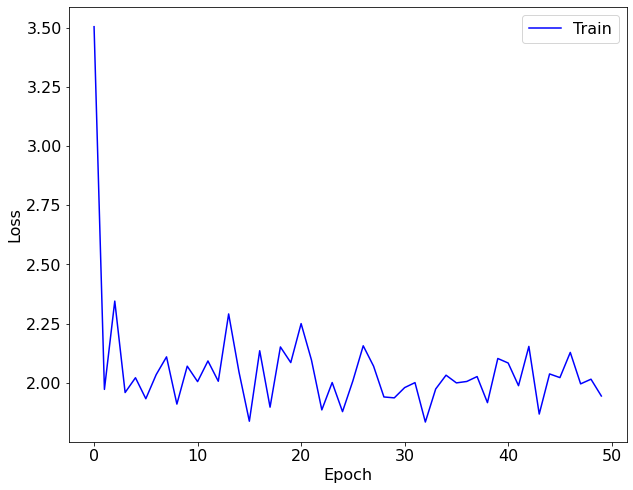

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10,8))


fnt=16
ax.plot(train_losses, color='blue', label='Train')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Loss", fontsize=fnt);

In [ ]:
def simple_embeddings(images, model):
  cuda = torch.cuda.is_available()
  with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(images), 20))
        k = 0
        for image in enumerate(images):
            if cuda:
                image = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(image).data.cpu().numpy()
  return embeddings

In [ ]:
from scipy.spatial.distance import cdist

queries = queries + 0
candidates_sets = candidates_sets + 0


print("True Labels")
print(queries_true)
dist_rank = []
for x in range(100):
  penta_rank = []
  for i in range(5):
    anchor_embeddings = simple_embeddings(torch.from_numpy(queries[x]).unsqueeze(0),mined_model)
    test_embeddings = simple_embeddings(torch.from_numpy(candidates_sets[x,i]).unsqueeze(0).unsqueeze(0),mined_model)
    distances=cdist(anchor_embeddings,test_embeddings,'cosine')
    penta_rank.append(distances)
  tmp = min(penta_rank)
  index = penta_rank.index(tmp)
  dist_rank.append(index+1)

print("Predictions: ")
print(np.asarray(dist_rank))
acc = np.count_nonzero(queries_true==dist_rank)

print("Accuracy: {}%".format(acc))



True Labels
[3 4 5 5 3 1 4 4 5 5 2 2 4 5 5 1 3 1 5 3 1 4 4 1 3 2 4 4 4 3 3 2 4 2 2 5 1
 2 3 1 1 4 2 1 1 4 5 4 4 2 1 2 1 1 1 3 3 1 3 5 2 5 4 2 5 4 1 4 4 4 4 3 5 3
 4 4 1 4 4 1 3 1 2 1 3 5 4 5 3 1 4 3 1 4 2 1 1 2 3 1]
Predictions: 
[3 4 5 5 3 1 4 4 5 5 2 2 4 1 5 1 3 1 5 3 1 4 2 1 3 2 4 4 4 3 3 2 4 2 2 5 1
 2 3 1 4 4 2 1 5 4 5 4 4 2 1 2 1 1 1 3 3 1 3 5 2 2 4 4 5 4 3 4 4 1 4 3 5 3
 4 4 1 4 4 1 3 1 2 1 3 5 4 5 3 1 4 3 1 4 2 1 1 2 3 1]
Accuracy: 92%


In [ ]:
from scipy.spatial.distance import cdist
from heapq import nsmallest
queries = queries + 0
candidates_sets = candidates_sets + 0

def test_model(query, candidates):

  penta_rank = []
  
  anchor_embeddings = simple_embeddings(torch.from_numpy(query).unsqueeze(0),mined_model)
  for i in range(5):
    test_embeddings = simple_embeddings(torch.from_numpy(candidates[i]).unsqueeze(0).unsqueeze(0),mined_model)
    distances=cdist(anchor_embeddings,test_embeddings,'cosine')
    penta_rank.append(distances)

  arr = numpy.array(penta_rank).flatten()
  i = np.argsort(np.asarray(arr))
  
  return i+1


In [ ]:
## test top-1
def test_top_1(query, candidates, query_true):
  sorted_indexes = test_model(query, candidates)
  return query_true == sorted_indexes[0]

## test top-3
def test_top_3(query, candidates, query_true):
  sorted_indexes = test_model(query, candidates)
  return np.isin(query_true, sorted_indexes[:3])

top_1_res = np.array([test_top_1(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])
top_3_res = np.array([test_top_3(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])

top_1 = np.count_nonzero(top_1_res) / queries.shape[0]
print(f"top-1 accuracy: {top_1}")

top_3 = np.count_nonzero(top_3_res) / queries.shape[0]
print(f"top-3 accuracy: {top_3}")


top-1 accuracy: 0.92
top-3 accuracy: 1.0
